In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from pathlib import Path
from urlpath import URL
import json
import glob 
import numpy as np
import seaborn as sns
from skimage.measure import shannon_entropy
import string
import nltk
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# https://pypi.org/project/pytesseract/
# sudo apt install tesseract-ocr
import pytesseract
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

from prepareCSV import cleanOcrText
pd.options.display.max_columns = None

[nltk_data] Downloading package words to /home/lilatee/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lilatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lilatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/lilatee/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /home/lilatee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_

In [8]:
df = pd.read_csv("./US_new_columns.csv")
df = df.loc[:, ["video_id", "thumbnail_link", 'region']]
region = df['region'][0]
print(df.shape)
df[:3]

(6283, 3)


,video_id,thumbnail_link,region
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US


### Pobieranie thumbnaili

In [ ]:
def readJSONList(path):
    with open(path, 'r') as file:
        loaded_list = json.loads(file.read())
    return loaded_list

def writeJSONList(path, list_to_save):
    with open(path, 'w') as file:
        file.write(json.dumps(list_to_save))

def downloadThumbnails(df, quality='hq'):
    list_of_ids_without_thumbnail = []
    ids = df["video_id"].values
    urls = df["thumbnail_link"].values
    
    region = df['region'][0]
    Path("./data/thumbnailsHQ/" + region).mkdir(parents=True, exist_ok=True)
    savepath = Path("./data/thumbnailsHQ/" + region)
    filename = quality + 'default.jpg'
    
    for id, url in zip(ids, urls): 
        temp_url = URL(url)
        temp_url = temp_url.parent / filename
        
        try:
            img = io.imread(str(temp_url))
        except Exception:
            list_of_ids_without_thumbnail.append(id)
            print(f"{id} no thumbnail")
            continue
        io.imsave(savepath / (id + ".png") , img)
    
    writeJSONList(savepath / "ids_without_thumbnail.txt", list_of_ids_without_thumbnail)
        
    return list_of_ids_without_thumbnail

In [ ]:
# list_of_ids_without_thumbnail = downloadThumbnails(df)
# df.loc[df.video_id=="0Yp9WS6cJFA",:]

### Średnia wartość kanałów w obrazie, entropia, ocr tesseract

In [4]:
%%time
# Odkomentować zapis jeśli trzeba!!!
imgs_path = Path(f'./data/thumbnailsHQ/{region}')

for i, img_path in enumerate(glob.glob(f"{imgs_path}/*.png")): 
    path = Path(img_path)
    img = io.imread(path)
    
    list_of_pixels = img.reshape(img.shape[0]*img.shape[1], 3)
    mean_of_channels = np.mean(list_of_pixels, axis=0)
    std_of_channels = np.std(list_of_pixels, axis=0)

    df.loc[df.video_id == path.stem, "mean_r"] = mean_of_channels[0]
    df.loc[df.video_id == path.stem, "mean_g"] = mean_of_channels[1]
    df.loc[df.video_id == path.stem, "mean_b"] = mean_of_channels[2]
    
    df.loc[df.video_id == path.stem, "std_r"] = std_of_channels[0]
    df.loc[df.video_id == path.stem, "std_g"] = std_of_channels[1]
    df.loc[df.video_id == path.stem, "std_b"] = std_of_channels[2]
    
    df.loc[df.video_id == path.stem, "entropy"] = shannon_entropy(img)
    df.loc[df.video_id == path.stem, "thumb_ocr_text"] = pytesseract.image_to_string(img)
    
    if (i % 100 == 0):
        print(i, end='\r')

df["clean_thumb_ocr_text"] = df.apply(lambda row: cleanOcrText(row.thumb_ocr_text), axis=1)

df.loc[:, "thumb_ocr_text"] = df.loc[:, "thumb_ocr_text"].fillna('')
df.loc[:, "clean_thumb_ocr_text"] = df.loc[:, "clean_thumb_ocr_text"].fillna('')

df.to_csv(f"./our_data/Etap2/etap2_{region}-tesseract.csv", index=False)
df[:3]

### CHECKPOINT

In [9]:
df = pd.read_csv(f"./our_data/Etap2/etap2_{region}-tesseract.csv")

In [ ]:
ocr_videos = df.loc[df.clean_thumb_ocr_text != '',:][["video_id","thumb_ocr_text","clean_thumb_ocr_text"]]
ocr_videos.shape

### Wizualizacja OCRa tesseract

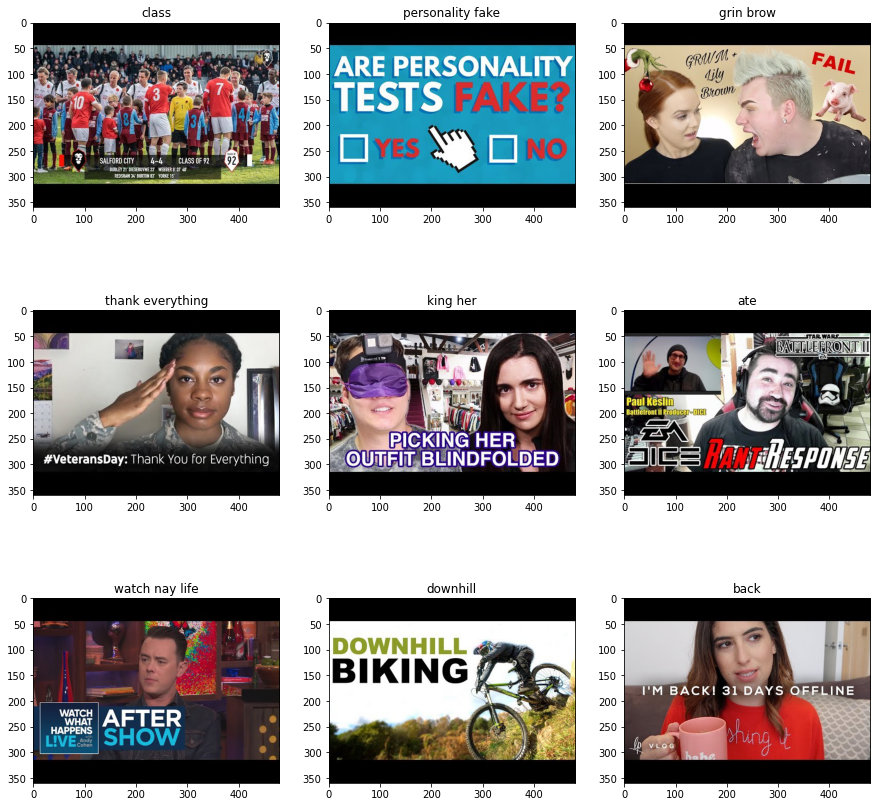

In [15]:
df.loc[:, "thumb_ocr_text"] = df.loc[:, "thumb_ocr_text"].fillna('')
df.loc[:, "clean_thumb_ocr_text"] = df.loc[:, "clean_thumb_ocr_text"].fillna('')

ocr_videos = df.loc[df.clean_thumb_ocr_text != '',:][["video_id","thumb_ocr_text","clean_thumb_ocr_text"]][:10]
test_ocr_videos_ids = ocr_videos.video_id.values

n_of_cols = 3
n_of_rows = int(ocr_videos.shape[0]/n_of_cols)
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*5, n_of_rows*5))

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        video = ocr_videos[i*n_of_cols+j:i*n_of_cols+j+1]
        video_id = video.video_id.values[0]
        path = Path(f'./data/thumbnailsHQ/{region}/{video_id}.png')
        
        ax.set_title(video.clean_thumb_ocr_text.values[0])
        img = io.imread(str(path))
        ax.imshow(img)

In [ ]:
ll = df.loc[df.clean_thumb_ocr_text != '',:][["thumb_ocr_text","clean_thumb_ocr_text"]].values
print(ll.shape)
print(df.shape)
# for el in ll:
#     print("="*100)
#     print(el[1])
#     print("="*100)
#     print(el[0])


### Lepszy OCR

#### [Rozpoznawanie napisów - https://github.com/clovaai/deep-text-recognition-benchmark](https://github.com/clovaai/deep-text-recognition-benchmark)

In [41]:
%run CRAFT-pytorch/test_modified.py \
    --trained_model="CRAFT-pytorch/craft_mlt_25k.pth" \
    --test_folder="data/thumbnailsHQ/{region}"\
    --cuda=True \
    --result_folder="data/OCR_result/{region}/"

data/OCR_result_CUDA_test/US/
Loading weights from checkpoint (CRAFT-pytorch/craft_mlt_25k.pth)
elapsed time : 2121.466652393341sailsHQ/US/__Wd-iOZQ6k.png


#### Wycięcie fragmentów obrazów z napisami

In [43]:
from skimage import io
import numpy as np
from pathlib import Path
import glob
import json

def genSlicesWithText(CRAFT_path_results=f"./data/OCR_result/{region}/", path_images=f"./data/thumbnailsHQ/{region}", out_df_path=f"our_data/Etap2/etap2_{region}_ocr.csv"):
    def bounding_box(points):
        x_coordinates, y_coordinates = zip(*points)
        return [(int(min(x_coordinates)), int(min(y_coordinates))), (int(max(x_coordinates)), int(max(y_coordinates)))]

    CRAFT_path_results = Path(CRAFT_path_results)
    path_images = Path(path_images)
    
    result_df = pd.DataFrame(columns=['video_id', 'word_id' ,'ocr_text', 'bbox'])
    for j, result_path in enumerate(glob.glob(str(CRAFT_path_results) + "/*.txt")):
        result_path = Path(result_path)
        video_id = result_path.stem[4:] # removing "res_" to obtain video_id
        
        img_path = Path(path_images / (video_id + ".png"))
        img = io.imread(img_path)
        shape = img.shape

        bboxes_path = CRAFT_path_results / ('res_' + img_path.stem + ".txt")
        bboxes = []
        with open(bboxes_path, "r") as bboxFile:
            for line in bboxFile.readlines():
                numbers = np.array(line.split(',')).astype(int)
                points = []

                for x,y in zip(numbers[::2], numbers[1::2]):
                    points.append((x, y))
                bboxes.append(bounding_box(points))


        if len(bboxes) > 0:
                Path(CRAFT_path_results / "words" / img_path.stem).mkdir(parents=True, exist_ok=True)
                img_dir = Path(CRAFT_path_results / "words" / img_path.stem)

        for i, bbox in enumerate(bboxes):
            img_slice = img[max(bbox[0][1], 0): min(bbox[1][1], shape[0]), max(bbox[0][0], 0):min(bbox[1][0], shape[1])]
            result_df = result_df.append({
                'video_id': video_id , 
                'word_id': i , 
                'ocr_text': '', 
                'bbox': json.dumps(bbox)}, ignore_index=True
            )
            
            io.imsave(img_dir / f"{i}.png", img_slice)
            
        if j % 100 == 0:
            print(j, end='\r')
            
    result_df.to_csv(out_df_path, index=False)

out_df_path = f"our_data/Etap2/etap2_{region}_ocr.csv"
genSlicesWithText(CRAFT_path_results=f"./data/OCR_result/{region}/", path_images=f"./data/thumbnailsHQ/{region}", out_df_path=out_df_path )

<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/aujUl3yt6nM/1.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/cIQKKzZtWwQ/0.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/D5D90CLAILY/0.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/ErZDtWsCA9U/7.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/M-wat3TSQqY/5.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/OTLw9G1WpC4/1.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)
<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/OWz3Fa_qK5Q/3.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/ryr75N0nki0/0.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/tySwY8qXwbQ/5.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)
<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/tySwY8qXwbQ/6.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


<ipython-input-43-7018cdf9417d>:49: UserWarning: data/OCR_result/US/words/yW6ORWYn3g0/5.png is a low contrast image
  io.imsave(img_dir / f"{i}.png", img_slice)


#### [Wykrywanie napisów - https://github.com/clovaai/CRAFT-pytorch](https://github.com/clovaai/CRAFT-pytorch)

In [39]:
%run deep-text-recognition-benchmark/demo_modified.py \
--Transformation TPS \
--FeatureExtraction ResNet \
--SequenceModeling BiLSTM \
--Prediction Attn \
--image_folder "data/OCR_result/{region}/words/" \
--saved_model "deep-text-recognition-benchmark/TPS-ResNet-BiLSTM-Attn.pth" \
--out_df_path "{out_df_path}"

### Łączenie wykrytych napisów w jeden, aby zapisać w kolumnie. Przed tym czyszczenie tzn.:
- usuwanie stopwords, 
- usuwanie słów krótszych niż 3, 
- lematyzacja,
- sprawdzenie czy słowo istnieje w słowniku.

### CHECKPOINT

In [40]:
df_ocr = pd.read_csv(f"./our_data/Etap2/etap2_{region}_ocr.csv")
df_ocr[:5]

,video_id,word_id,ocr_text,bbox
0,-5WBCrazSfg,0,2,"[[94, 74], [116, 108]]"
1,-5WBCrazSfg,1,2,"[[94, 112], [116, 137]]"
2,-5WBCrazSfg,2,2,"[[56, 160], [82, 190]]"
3,-5WBCrazSfg,3,2,"[[128, 162], [148, 192]]"
4,-5WBCrazSfg,4,2,"[[89, 198], [113, 229]]"


In [41]:
from prepareCSV import concatAndCleanOcrTextV2
df_ocr = df_ocr.groupby(by="video_id", axis=0).apply(lambda x: concatAndCleanOcrTextV2(x)).reset_index()
df_ocr.to_csv(f"our_data/Etap2/etap2_{region}_ocr_groupby.csv", index=False)
df_ocr[:10]

,video_id,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes
0,-5WBCrazSfg,2 2 2 2 2 dream side 5 a,dream side,"[""[[33, 266], [217, 309]]"", ""[[333, 266], [446..."
1,0-VAnh7r-_8,destinyt2 forsaken 3if,forsaken,"[""[[9, 73], [173, 93]]""]"
2,09lz1fRBBsY,inoutheality lil peep drangs,peep,"[""[[217, 213], [394, 286]]""]"
3,0ANDjPQPS_Q,thank you ponelocks youlobe,thank,"[""[[1, 134], [163, 200]]""]"
4,0AUFyFEt35g,smtown official,official,"[""[[108, 268], [193, 285]]""]"
5,0DpCDxoj_Xg,christmas carpool,,[]
6,0GQmGOju6CE,meet ghost my,meet ghost,"[""[[21, 253], [108, 300]]"", ""[[165, 253], [265..."
7,0JcNT6jYGwI,worst best of the episode 65 houg plinketto,bad best episode,"[""[[272, 52], [468, 104]]"", ""[[13, 53], [197, ..."
8,0NS51Iph2Ms,fox news channel,fox news channel,"[""[[40, 230], [101, 258]]"", ""[[25, 258], [102,..."
9,0NWKUHl6JLY,nindies 2018 showcase spring switter nintendo,showcase spring,"[""[[201, 161], [312, 181]]"", ""[[314, 161], [38..."


### Dodanie kolumny z wynikami nowego OCRa

In [45]:
df_ocr = df_ocr.set_index("video_id")
df = df.set_index("video_id").join(df_ocr).reset_index()
df["bboxes"] = df["bboxes"].fillna(json.dumps([]))
df[:5]

,video_id,thumbnail_link,region,r,g,b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes
0,Jw1Y-zhQURU,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,3s1rvMFUweQ,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.502830,71.743704,79.699635,6.470819,\n,NaN,wigy water an vevo,water,"[""[[282, 116], [468, 204]]""]"
3,PUTEiSjKwJU,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,GB,86.534334,73.284271,69.150666,6.839139,\n\ney tderr ott\n\nSTE a CLASS OF 92\n...,class,3 10 3 92 salford city class of 92 4 dudley2n ...,city class burton,"[""[[174, 262], [197, 277]]"", ""[[280, 262], [31..."
4,rHwDegptbI4,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


### Wizualizacja OCRa V2

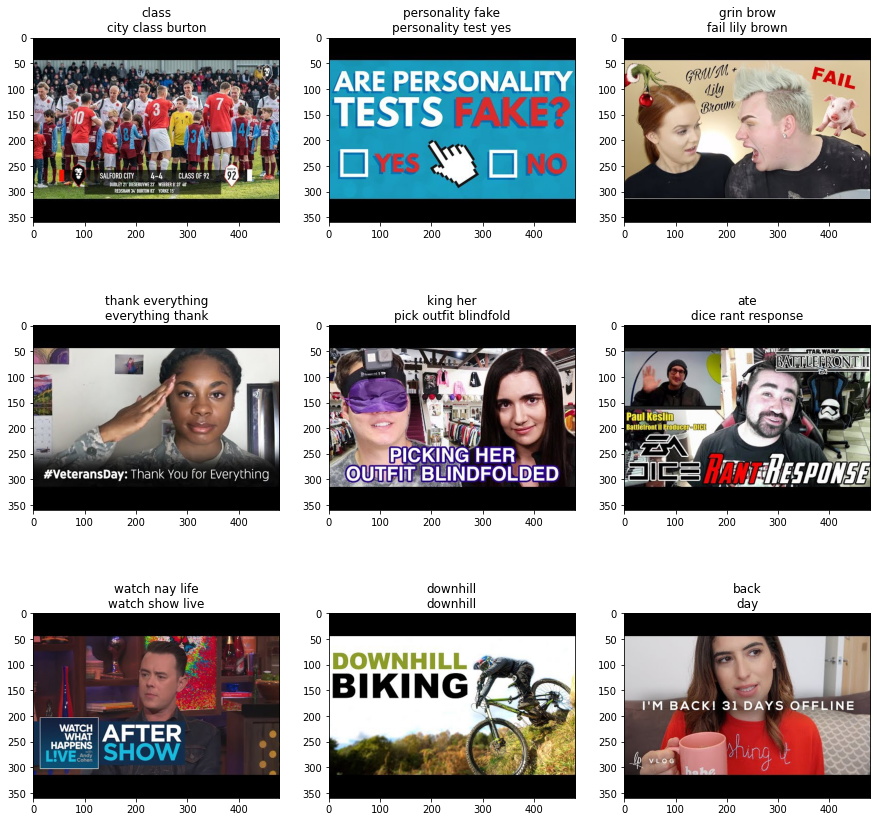

In [54]:
df = pd.read_csv(f"./our_data/Etap2/etap2_{region}-V2.csv")

df.loc[:, "thumb_ocr_text_V2"] = df.loc[:, "thumb_ocr_text_V2"].fillna('')
df.loc[:, "clean_thumb_ocr_text_V2"] = df.loc[:, "clean_thumb_ocr_text_V2"].fillna('')

# ocr_videos = df.loc[df.clean_thumb_ocr_text_V2 != '',:][["video_id","thumb_ocr_text_V2","clean_thumb_ocr_text_V2"]][:10]
ocr_videos = df.loc[df.video_id.isin(test_ocr_videos_ids), :]
# test_ocr_videos_ids = ocr_videos.video_id.values

n_of_cols = 3
n_of_rows = int(ocr_videos.shape[0]/n_of_cols)
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*5, n_of_rows*5))

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        video = ocr_videos[i*n_of_cols+j:i*n_of_cols+j+1]
        video_id = video.video_id.values[0]
        path = Path(f'./data/thumbnailsHQ/{region}/{video_id}.png')
        
        ax.set_title(f"{video.clean_thumb_ocr_text.values[0]}\n{video.clean_thumb_ocr_text_V2.values[0]}")
        img = io.imread(str(path))
        ax.imshow(img)

### Dodanie kolumny zawierającej średni punkt napisów w obrazie

In [46]:
def avg_texts_coords(bboxes):
    bboxes = json.loads(bboxes)
    if (len(bboxes) == 0):
        return json.dumps([-1, -1])
    middle_corrds_of_texts = []
    for bbox in bboxes:
        p1, p2 = json.loads(bbox)
        p1 = np.array(p1)
        p2 = np.array(p2)
        middle_text_coords = np.mean([p1, p2], axis=0)
        middle_corrds_of_texts.append(middle_text_coords)
#         print(p1, p2)
#         print(middle_text_coords)
    
    return json.dumps(list(np.mean(middle_corrds_of_texts, axis=0)))
    
df["avg_texts_coords"] = df.apply(lambda row: avg_texts_coords(row.bboxes), axis=1) 
df["avg_texts_coordX"] = df.apply(lambda row: json.loads(row.avg_texts_coords)[0],axis=1)
df["avg_texts_coordY"] = df.apply(lambda row: json.loads(row.avg_texts_coords)[1],axis=1)

df.to_csv(f"./our_data/Etap2/etap2_{region}-V2.csv", index=False)
df[:5]

,video_id,thumbnail_link,region,r,g,b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY
0,Jw1Y-zhQURU,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000
1,3s1rvMFUweQ,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.502830,71.743704,79.699635,6.470819,\n,NaN,wigy water an vevo,water,"[""[[282, 116], [468, 204]]""]","[375.0, 160.0]",375.000000,160.000000
3,PUTEiSjKwJU,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,GB,86.534334,73.284271,69.150666,6.839139,\n\ney tderr ott\n\nSTE a CLASS OF 92\n...,class,3 10 3 92 salford city class of 92 4 dudley2n ...,city class burton,"[""[[174, 262], [197, 277]]"", ""[[280, 262], [31...","[231.83333333333334, 279.1666666666667]",231.833333,279.166667
4,rHwDegptbI4,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]",-1.000000,-1.000000


### CHECKPOINT

In [7]:
df = pd.read_csv(f"./our_data/Etap2/etap2_{region}-V2.csv")
df[:5]

,video_id,thumbnail_link,region,r,g,b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords
0,Jw1Y-zhQURU,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]"
1,3s1rvMFUweQ,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]"
2,n1WpP7iowLc,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,GB,66.502830,71.743704,79.699635,6.470819,\n,NaN,wigy water an vevo,water,"[""[[282, 116], [468, 204]]""]","[375.0, 160.0]"
3,PUTEiSjKwJU,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,GB,86.534334,73.284271,69.150666,6.839139,\n\ney tderr ott\n\nSTE a CLASS OF 92\n...,class,3 10 3 92 salford city class of 92 4 dudley2n ...,city class burton,"[""[[174, 262], [197, 277]]"", ""[[280, 262], [31...","[231.83333333333334, 279.1666666666667]"
4,rHwDegptbI4,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[-1, -1]"


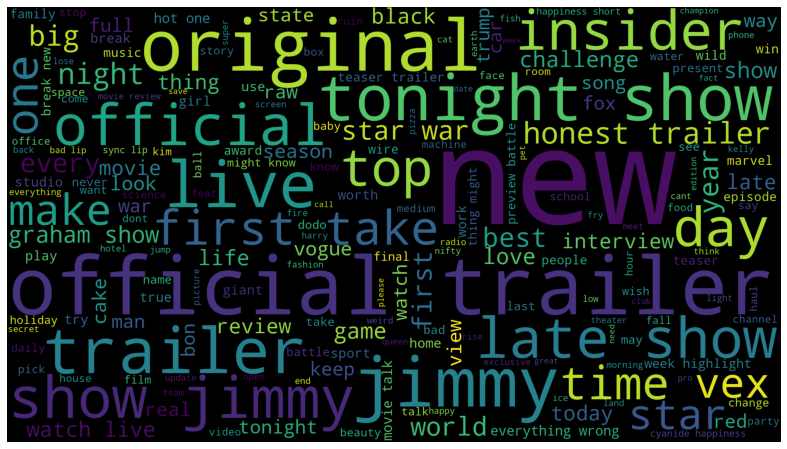

In [53]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.pyplot import figure

df.loc[:, "clean_thumb_ocr_text_V2"] = df.loc[:, "clean_thumb_ocr_text_V2"].fillna('')
all_words = ' '.join(df.loc[:, "clean_thumb_ocr_text_V2"].values)

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1920, height=1080).generate(all_words)

figure(figsize=(16, 8))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Analiza sentymentu

In [18]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

df["clean_thumb_ocr_text_V2"] = df["clean_thumb_ocr_text_V2"].fillna('')
df["ocr_sentiment_compound"] = df.apply(lambda row: sia.polarity_scores(row.clean_thumb_ocr_text_V2)['compound'] ,axis=1)
df.to_csv(f"./our_data/Etap2/etap2_{region}-V2.csv", index=False)
df[:5]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,video_id,thumbnail_link,region,mean_r,mean_g,mean_b,std_r,std_g,std_b,entropy,thumb_ocr_text,clean_thumb_ocr_text,thumb_ocr_text_V2,clean_thumb_ocr_text_V2,bboxes,avg_texts_coords,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound
0,2kyS6SvSYSE,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,US,83.791198,77.128183,74.980914,78.653796,73.570512,73.087883,6.818234,\n,NaN,NaN,,[],"[-1, -1]",-1.00,-1.000000,0.0000
1,1ZAPwfrtAFY,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,US,53.131123,50.240133,55.462459,66.342402,62.884021,62.213755,6.185228,\n,NaN,the trump presidency,trump presidency,"[""[[68, 169], [105, 178]]"", ""[[108, 169], [176...","[114.25, 173.5]",114.25,173.500000,0.0000
2,5qpjK5DgCt4,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,[],"[-1, -1]",-1.00,-1.000000,0.0000
3,puqaWrEC7tY,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,US,85.942714,86.987807,84.269149,85.556903,83.919807,85.287368,6.434697,\n,NaN,this at look photograph gmm youlube originals,look photograph original,"[""[[262, 169], [334, 216]]"", ""[[269, 190], [41...","[289.0, 235.66666666666666]",289.00,235.666667,0.3182
4,d380meD0W0M,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,US,111.840347,103.171238,102.399716,104.868991,96.903546,93.691704,6.510005,\n,NaN,going baldzi dare youi,dare,"[""[[0, 262], [94, 297]]""]","[47.0, 279.5]",47.00,279.500000,0.0000
